In [ ]:
# default_exp layers

# Layers

> Custom activations, layers, and layer blocks are contained in this module.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Used in notebook but not needed in package.
import matplotlib.pyplot as plt

## Activations

In [ ]:
# export
class GRelu(nn.Module):
    """Generic ReLU."""

    def __init__(self, leak=0.0, max=float('inf'), sub=0.0):
        super().__init__()
        self.leak = leak
        self.max = max
        self.sub = sub

    def forward(self, x):
        """Check which operations are necessary to save computation."""
        x = F.leaky_relu(x, self.leak) if self.leak else F.relu(x)
        if self.sub:
            x -= self.sub
        if self.max:
            x = torch.clamp(x, max=self.max)
        return x

    def __repr__(self):
        return f'GReLU(leak={self.leak}, max={self.max}, sub={self.sub})'

In [ ]:
# export
JRelu = GRelu(leak=.1, sub=.4, max=6.0)

In [ ]:
# export
class Mish(nn.Module):
    """OOP form of mish activation.

    Mish: A Self Regularized Non-Monotonic Neural Activation Function
    https://arxiv.org/pdf/1908.08681v1.pdf
    """

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

In [ ]:
# export
def mish(x):
    """Functional form of mish activation.

    Mish: A Self Regularized Non-Monotonic Neural Activation Function
    https://arxiv.org/pdf/1908.08681v1.pdf

    Parameters
    ----------
    x: torch.Tensor[float]
        Input tensor.
    Returns
    -------
    torch.Tensor[float]: Tensor of same shape as input x.
    """
    return x * torch.tanh(F.softplus(x))

In [ ]:
def plot_activations(z, a, mode='scatter', **kwargs):
    """Plot an input tensor and its corresponding activations.  Both tensors
    will be flattened for plotting.
    
    Parameters
    ----------
    z: tf.Tensor
        Tensor containing values to plot on the x axis (we can often think of
        this as the output of a linear layer, where z=f(x) and a=mish(z)).
    a: tf.Tensor
        Tensor containing values to plot on y axis.
    mode: str
        'scatter' for scatter plot or 'plot' for line plot.
    kwargs: Values to be passed to the matplotlib plotting function, such as 
        's' when in 'scatter' mode or 'lw' in 'plot' mode.
        
    Returns
    -------
    None
    """
    plt_func = getattr(plt, mode)
    kwargs = kwargs or {}
    if mode == 'scatter' and not kwargs:
        kwargs = {'s': .75}
    plt_func(z.numpy().flatten(), a.numpy().flatten(), **kwargs)
    plt.axvline(0, lw=.5, alpha=.5)
    plt.axhline(0, lw=.5, alpha=.5)
    plt.show()

In [ ]:
x = torch.arange(-5, 5, .05)
a = mish(x)

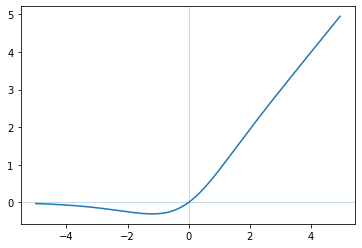

In [ ]:
plot_activations(x, a, 'plot')

## Layer Blocks

In [ ]:
# export
class ConvBlock(nn.Module):
    """Create a convolutional block optionally followed by a batch norm layer.
    """

    def __init__(self, c_in, c_out, kernel_size=3, norm=True, activation=JRelu,
                 **kwargs):
        """
        Parameters
        -----------
        c_in: int
            # of input channels.
        c_out: int
            # of output channels.
        kernel_size: int
            Size of kernel in conv2d layer. An integer argument will be used
            as both the height and width.
        norm: bool
            If True, include a batch norm layer after the conv layer. If False,
            no norm layer will be used. Note that batch norm has learnable
            affine parameters which remove the need for a bias in the preceding
            conv layer. When batch norm is not used, however, the conv layer
            will include a bias term.
        activation: nn.Module
            Activation function to use at the end of the convolutional block.
            (In some cases such as our ResBlock implementation, we pass in None
            so that an extra addition can be performed before the final
            activation.) Do not use the functional form here as it will be
            added to a sequential object.
        kwargs: any
            Additional keyword args are passed to Conv2d. Useful kwargs include
            stride, and padding (see pytorch docs for nn.Conv2d).
        """
        super().__init__()
        self.norm = norm
        layers = [nn.Conv2d(c_in, c_out, kernel_size, bias=not norm, **kwargs)]
        if norm:
            layers.append(nn.BatchNorm2d(c_out))
        if activation is not None:
            layers.append(activation)
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [ ]:
conv = ConvBlock(3, 5, norm=False)
conv

ConvBlock(
  (block): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): GReLU(leak=0.1, max=6.0, sub=0.4)
  )
)

In [ ]:
x = torch.rand(2, 3, 4, 4)
conv(x).shape

torch.Size([2, 5, 2, 2])

In [ ]:
# export
class ResBlock(nn.Module):

    def __init__(self, c_in, activation=JRelu, f=3, stride=1, pad=1,
                 skip_size=2, norm=True):
        """Residual block to be used in CycleGenerator. Note that f, stride,
        and pad must be selected such that the height and width of the input
        remain the same.

        Parameters
        -----------
        c_in: int
            # of input channels.
        activation: callable
            Activation function to use.
        f: int
            Size of filter (f x f) used in convolution. Default 3.
        stride: int
            # of pixels the filter moves between each convolution. Default 1.
        pad: int
            Pixel padding around the input. Default 1.
        skip_size: int
            Number of conv blocks inside the skip connection (default 2).
            ResNet paper notes that skipping a single layer did not show
            noticeable improvements.
        norm: bool
            Specifies whether to include a batch norm layer after each conv
            layer.
        """
        super().__init__()
        self.skip_size = skip_size
        self.layers = nn.ModuleList([
            ConvBlock(c_in, c_in, norm=norm, activation=None, kernel_size=f,
                      stride=stride, padding=pad)
            for i in range(skip_size)
        ])
        self.activation = activation

    def forward(self, x):
        x_out = x
        for i, layer in enumerate(self.layers):
            x_out = layer(x_out)

            # Final activation must be applied after addition.
            if i != self.skip_size - 1:
                x_out = self.activation(x_out)

        return self.activation(x + x_out)

In [ ]:
ResBlock(4)

ResBlock(
  (layers): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (activation): GReLU(leak=0.1, max=6.0, sub=0.4)
)

In [ ]:
ResBlock(4, norm=False)

ResBlock(
  (layers): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (activation): GReLU(leak=0.1, max=6.0, sub=0.4)
)